In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl 
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [3]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/home/ssl/.fastai/data/mnist.pkl.gz')

In [4]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [5]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n,c = x_train.shape

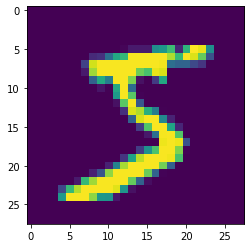

In [6]:
img = x_train[0]
plt.imshow(img.view(28,28))

In [7]:
img.view(28,28).type()

'torch.FloatTensor'

Initial python model

In [8]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)

In [9]:
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    c=torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i,j] += a[i,k]*b[k,j]
    return c

In [10]:
m1 = x_valid[:5]
m2 = weights

In [11]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [12]:
%time t1=matmul(m1,m2)

CPU times: user 842 ms, sys: 0 ns, total: 842 ms
Wall time: 842 ms


In [13]:
t1.shape

torch.Size([5, 10])

In [14]:
len(x_train)

50000

Speeding up the computation

In [15]:
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    c=torch.zeros(ar,bc)
    for i in range(ar):
        for j in range(bc):
            c[i,j] = (a[i,:]*b[:,j]).sum()
    return c

In [16]:
%time t1=matmul(m1,m2)

CPU times: user 1.57 ms, sys: 217 µs, total: 1.79 ms
Wall time: 1.39 ms


In [17]:
a = tensor([10,20,30])

In [18]:
m = tensor([[1,2,3],
           [4,5,6],
           [7,8,9]])

In [19]:
a[:, None] + m

tensor([[11, 12, 13],
        [24, 25, 26],
        [37, 38, 39]])

In [20]:
def matmul(a,b):
    ar, ac = a.shape
    br, bc = b.shape
    assert ac==br
    c=torch.zeros(ar,bc)
    for i in range(ar):
        c[i] = (a[i].unsqueeze(-1)*b).sum(dim=0)
    return c

In [21]:
%timeit -n 10 _=matmul(m1,m2)

237 µs ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%timeit -n 10 _=m1.matmul(m2)

The slowest run took 4.52 times longer than the fastest. This could mean that an intermediate result is being cached.
8.17 µs ± 6.62 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
def normalize(x, m, s): return (x-m)/s

In [24]:
train_mean, train_std = x_train.mean(), x_train.std()

Why mean and std should be 0 and 1 respectively?

In [25]:
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [26]:
x_train.mean(), x_train.std()

(tensor(-7.6999e-06), tensor(1.))

In [27]:
n,m = x_train.shape
c = y_train.max() + 1
n,m,c

(50000, 784, tensor(10))

## Creating the model

In [28]:
nh=50 #Hidden network

What was the reason to select number of hidden units as 50?

In [29]:
w1 = torch.randn(m,nh)/math.sqrt(m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)/math.sqrt(nh)
b2 = torch.zeros(1)

In [30]:
w1.mean(), w1.std()

(tensor(-0.0002), tensor(0.0357))

In [31]:
w2.mean(), w2.std()

(tensor(0.0207), tensor(0.1483))

In [32]:
def lin(x, w, b): return x@w + b

In [33]:
t = lin(x_valid, w1, b1)

In [34]:
t.mean(), t.std()

(tensor(0.0603), tensor(0.9601))

In [35]:
def relu(x): return x.clamp_min(0.)

In [36]:
t = relu(lin(x_valid, w1, b1)) - 0.5

In [37]:
t.mean(), t.std()

(tensor(-0.0893), tensor(0.5851))

In [38]:
w1 = torch.randn(m,nh)*math.sqrt(2/m)
b1 = torch.zeros(nh)
w2 = torch.randn(nh,1)*math.sqrt(2/nh)
b2 = torch.zeros(1)

In [39]:
t = relu(lin(x_valid, w1, b1))
t.mean(), t.std()

(tensor(0.5902), tensor(0.8438))

Let's do a forward pass

In [40]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [41]:
%timeit -n 10 _=model(x_valid)

4.06 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now let's find a loss function

In [42]:
model(x_valid).shape

torch.Size([10000, 1])

In [43]:
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

In [44]:
y_train, y_valid = y_train.float(), y_valid.float()

In [45]:
preds = model(x_train)

In [46]:
preds.shape

torch.Size([50000, 1])

In [47]:
mse(preds, y_train)

tensor(32.1268)

Gradients and Backward propogation

In [48]:
def mse_grad(inp, targ):
    inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / inp.shape[0]

In [49]:
def relu_grad(inp, out):
    inp.g = (inp>0).float() * out.g

In [50]:
def lin_grad(inp, out, w, b):
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [51]:
def forward_and_backward(inp, targ):
    # Forward pass
    l1 = inp @ w1 + b1
    l2 = relu(l1)
    out = l2 @ w2 + b2
    loss = mse(out, targ)
    
    # Backward pass
    mse_grad(out, targ)
    lin_grad(l2, out, w2, b2)
    relu_grad(l1, l2)
    lin_grad(inp, l1, w1, b1)

In [52]:
forward_and_backward(x_train, y_train)

In [53]:
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig = x_train.g.clone()

In [54]:
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)
xt2 = x_train.clone().requires_grad_(True)

In [55]:
def forward(inp, targ):
    # Forward pass
    l1 = inp @ w12 + b12
    l2 = relu(l1)
    out = l2 @ w22 + b22
    return mse(out, targ) 

In [56]:
loss = forward(xt2, y_train)

In [57]:
loss.backward()

In [58]:
w12.grad, w1.g

(tensor([[ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         ...,
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922]]),
 tensor([[ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         ...,
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922]]))

## Refactoring

Writing layers as classes

In [59]:
class ReLU():
    def __call__(self, inp):
        self.inp = inp
        self.out = inp.clamp_min(0.) - 0.5
        return self.out
    
    def backward(self): self.inp.g = (self.inp>0).float() * self.out.g

In [60]:
class Lin():
    def __init__(self, w, b): self.w, self.b = w,b
    def __call__(self, inp):
        self.inp = inp
        self.out = inp@self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.t()
        self.w.g = (self.inp.unsqueeze(-1) * self.out.g.unsqueeze(1)).sum(0)
        self.b.g = self.out.g.sum(0)

In [61]:
class Mse:
    def __call__(self, inp, targ):
        self.inp = inp
        self.targ = targ
        self.out = (inp.squeeze() - targ).pow(2).mean()
        return self.out
    
    def backward(self):
        self.inp.g = 2. * (self.inp.squeeze() - self.targ).unsqueeze(-1) / self.targ.shape[0]

In [62]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), ReLU(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [63]:
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model(w1, b1, w2, b2)

In [64]:
%time loss = model(x_train, y_train)

CPU times: user 89 ms, sys: 0 ns, total: 89 ms
Wall time: 22 ms


In [65]:
%time model.backward()

CPU times: user 4.84 s, sys: 2.28 s, total: 7.12 s
Wall time: 1.82 s


In [66]:
w1.g, w1g

(tensor([[ 0.5350,  0.4520,  0.3186,  ..., -0.6616,  0.6195,  0.2402],
         [ 0.5350,  0.4520,  0.3186,  ..., -0.6616,  0.6195,  0.2402],
         [ 0.5350,  0.4520,  0.3186,  ..., -0.6616,  0.6195,  0.2402],
         ...,
         [ 0.5350,  0.4520,  0.3186,  ..., -0.6616,  0.6195,  0.2402],
         [ 0.5350,  0.4520,  0.3186,  ..., -0.6616,  0.6195,  0.2402],
         [ 0.5350,  0.4520,  0.3186,  ..., -0.6616,  0.6195,  0.2402]]),
 tensor([[ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         ...,
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922],
         [ 0.6475,  0.5426,  0.3878,  ..., -0.8039,  0.7521,  0.2922]]))

# Module forward

In [67]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('Not Implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [68]:
class ReLU(Module):
    def forward(self, inp): return inp.clamp_min(0.) - 0.5    
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g

In [69]:
class Lin(Module):
    def __init__(self, w, b): self.w, self.b = w,b
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("bi,bj->ij", inp, out.g)
        self.b.g = out.g.sum(0)

In [70]:
class Mse(Module):
    def forward(self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
        
    def bwd(self, out, inp, targ): inp.g = 2. * (inp.squeeze() - targ).unsqueeze(-1) / targ.shape[0]

In [71]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1, b1), ReLU(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [72]:
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model()

In [73]:
%time loss = model(x_train, y_train)

CPU times: user 111 ms, sys: 15.4 ms, total: 126 ms
Wall time: 31.4 ms


In [74]:
%time model.backward()

CPU times: user 184 ms, sys: 50.4 ms, total: 234 ms
Wall time: 58.3 ms


In [75]:
class Lin(Module):
    def __init__(self, w, b): self.w, self.b = w,b
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [76]:
w1.g, b1.g, w2.g, b2.g = [None]*4
model = Model()

In [77]:
%time loss = model(x_train, y_train)

CPU times: user 86.7 ms, sys: 1.11 ms, total: 87.8 ms
Wall time: 21.7 ms


In [78]:
%time model.backward()

CPU times: user 166 ms, sys: 71.4 ms, total: 237 ms
Wall time: 59.1 ms


## Implementing using PyTorch

In [79]:
from torch import nn

In [80]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        self.loss = mse
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x.squeeze().float(), targ.float())

In [81]:
model = Model(m, nh, 1)

In [82]:
%time loss = model(x_train, y_train)

CPU times: user 87.2 ms, sys: 1.25 ms, total: 88.5 ms
Wall time: 21.9 ms


In [83]:
%time loss.backward()

CPU times: user 97.8 ms, sys: 573 µs, total: 98.4 ms
Wall time: 24.6 ms
